    Excitation Wavelength (nm)       Par Avg      Perp Avg Cj (Par / Perp)
0                          450  16820.789394  19200.658423        0.876053
1                          451  18078.423885  20597.408066        0.877704
2                          452  19360.496077  21881.714281         0.88478
3                          453  20472.696628  23198.008396         0.88252
4                          454  21806.434975  24687.989902        0.883281
5                          455  23419.070395   26107.50484        0.897024
6                          456  24418.285677  27656.307149        0.882919
7                          457  25612.319054  29139.905329        0.878943
8                          458  26794.558628  30327.664805        0.883502
9                          459  28487.016099  31950.101663         0.89161
10                         460  30014.214902  34089.967972        0.880441
11                         461  31194.079867  35305.430718        0.883549
12                       

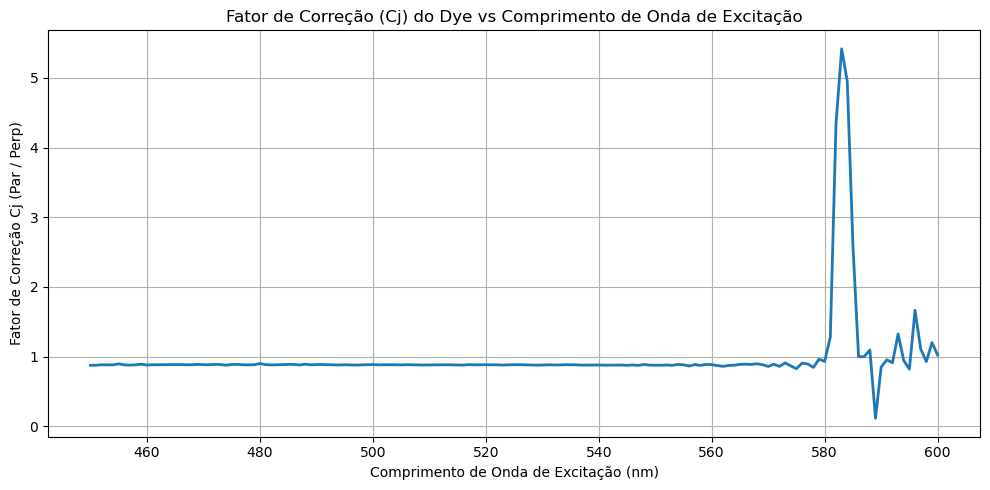

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Funções utilitárias ===

def load_and_clean_csv(filepath: str) -> pd.DataFrame:
    df_raw = pd.read_csv(filepath, header=None)
    df_clean = df_raw.drop(index=[0, 1]).reset_index(drop=True)
    df_clean.iloc[:, 0] = df_clean.iloc[:, 0].astype(float)
    df_clean.iloc[:, 1:] = df_clean.iloc[:, 1:].astype(float)
    return df_clean

def split_signal_and_lamp(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    lambda_em = df.iloc[:-1, 0].values
    signal = df.iloc[:-1, 1:].values  # [n_emissão x n_excitação]
    lamp = df.iloc[-1, 1:].values     # [n_excitação]
    return lambda_em, signal, lamp

def subtract_background(signal: np.ndarray, bg: float) -> np.ndarray:
    return signal - bg

def correct_by_lamp(signal: np.ndarray, lamp: np.ndarray) -> np.ndarray:
    return signal / lamp  # broadcasting por coluna (excitação)

# === Pipeline principal ===

# Carregar dados
par_df = load_and_clean_csv("data/par_dye.csv")
perp_df = load_and_clean_csv("data/perp_dye.csv")

# Extrair λ_em, sinais e função da lâmpada
lambda_em, par_signal, lamp = split_signal_and_lamp(par_df)
_, perp_signal, _ = split_signal_and_lamp(perp_df)

# Subtrair fundo
bg = 990
par_bg = subtract_background(par_signal, bg)
perp_bg = subtract_background(perp_signal, bg)

# Corrigir pela função da lâmpada
par_corr = correct_by_lamp(par_bg, lamp)
perp_corr = correct_by_lamp(perp_bg, lamp)

# Encontrar índice do pico de emissão (λ₀ ≈ 583 nm)
lambda_0 = 583.0
i_star = np.argmin(np.abs(lambda_em - lambda_0))

# Selecionar janela simétrica de 15 pontos ao redor de λ₀
window_size = 15
half_window = window_size // 2
start_idx = max(i_star - half_window, 0)
end_idx = min(i_star + half_window + 1, len(lambda_em))
if end_idx - start_idx < window_size:
    if start_idx == 0:
        end_idx = start_idx + window_size
    elif end_idx == len(lambda_em):
        start_idx = end_idx - window_size

# Calcular médias sobre a janela para cada excitação
par_avg = par_corr[start_idx:end_idx, :].mean(axis=0)
perp_avg = perp_corr[start_idx:end_idx, :].mean(axis=0)

# Calcular fator de correção Cj = I∥ / I⊥
Cj = par_avg / perp_avg

# Construir DataFrame final
excitation_wavelengths = np.arange(450, 601)
df_result = pd.DataFrame({
    "Excitation Wavelength (nm)": excitation_wavelengths,
    "Par Avg": par_avg,
    "Perp Avg": perp_avg,
    "Cj (Par / Perp)": Cj,
})

# Salvar ou exibir
print(df_result.head(20))
df_result.to_csv("correcao_dye_resultado.csv", index=False)


# Se você estiver rodando logo após o cálculo, reutilize df_result diretamente
wavelengths = df_result["Excitation Wavelength (nm)"]
Cj_values = df_result["Cj (Par / Perp)"]

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, Cj_values, linewidth=2)
plt.title("Fator de Correção (Cj) do Dye vs Comprimento de Onda de Excitação")
plt.xlabel("Comprimento de Onda de Excitação (nm)")
plt.ylabel("Fator de Correção Cj (Par / Perp)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# === Utilitários ===
def clean_ple_csv(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath, header=None)
    df_clean = df.drop(index=[0, 1]).reset_index(drop=True)
    df_clean[df_clean.columns[0]] = df_clean.iloc[:, 0].astype(float)
    df_clean.iloc[:, 1:] = df_clean.iloc[:, 1:].astype(float)
    return df_clean

def split_signal_and_lamp(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    lambda_em = df.iloc[:-1, 0].values
    signal = df.iloc[:-1, 1:].values
    lamp = df.iloc[-1, 1:].values
    return lambda_em, signal, lamp

def subtract_background(signal: np.ndarray, bg: float = 990.0) -> np.ndarray:
    return signal - bg

def correct_by_lamp(signal: np.ndarray, lamp: np.ndarray) -> np.ndarray:
    return signal / lamp

# === Pipeline ===

# Caminhos dos arquivos
par_path = "data/Zb571_CHCl3_par.csv"
perp_path = "data/Zb571_CHCl3_perp.csv"
cj_path = "correcao_dye_resultado.csv"  # precisa conter a coluna "Cj (Par / Perp)"

# Carregar e limpar
df_par = clean_ple_csv(par_path)
df_perp = clean_ple_csv(perp_path)

# Extrair λ_em, sinais e lâmpada
lambda_em, par_signal, lamp = split_signal_and_lamp(df_par)
_, perp_signal, _ = split_signal_and_lamp(df_perp)

# Subtrair fundo e corrigir pela lâmpada
bg = 990
par_corr = correct_by_lamp(subtract_background(par_signal, bg), lamp)
perp_corr = correct_by_lamp(subtract_background(perp_signal, bg), lamp)

# Selecionar janela ao redor do pico de emissão λ₀ ≈ 583 nm
lambda_0 = 583.0
window_size = 15
half_window = window_size // 2
i_star = np.argmin(np.abs(lambda_em - lambda_0))
start_idx = max(i_star - half_window, 0)
end_idx = min(i_star + half_window + 1, len(lambda_em))
if end_idx - start_idx < window_size:
    if start_idx == 0:
        end_idx = start_idx + window_size
    else:
        start_idx = end_idx - window_size

# Média nas janelas
par_avg = par_corr[start_idx:end_idx, :].mean(axis=0)
perp_avg = perp_corr[start_idx:end_idx, :].mean(axis=0)

# === Aplicar correção do dye ===
df_cj = pd.read_csv(cj_path)
Cj = df_cj["Cj (Par / Perp)"].values

perp_corrected = perp_avg * Cj

# Calcular anisotropia
anisotropy = (par_avg - perp_corrected) / (par_avg + 2 * perp_corrected)

# Calcular energia relativa
lambda_ex = np.arange(450, 601)
energy_relative = 1240 / lambda_ex - 1240 / lambda_0

# Construir dataframe final
df_final = pd.DataFrame({
    "Excitation Wavelength (nm)": lambda_ex,
    "Par Avg": par_avg,
    "Perp Avg": perp_avg,
    "Correction Factor (Cj)": Cj,
    "Perp Corrected": perp_corrected,
    "Anisotropy": anisotropy,
    "Energy Relative to 583 nm (eV)": energy_relative
})

# Visualizar resultado
print(df_final.head(10))


   Excitation Wavelength (nm)        Par Avg       Perp Avg  \
0                         450  251376.735757  290352.205842   
1                         451  253826.552426  293560.397839   
2                         452  253153.385378  292248.490205   
3                         453  253330.605807  293517.878808   
4                         454  255059.147158   293778.45961   
5                         455  254453.805191  293535.937274   
6                         456  253620.561405  291919.427907   
7                         457  251206.079215  289625.231989   
8                         458  251409.957782  289324.244274   
9                         459  254206.273574  292207.549537   

   Correction Factor (Cj) Perp Corrected Anisotropy  \
0                0.876053  254363.845079   -0.00393   
1                0.877704  257659.084626  -0.004983   
2                0.884780  258575.524551  -0.007039   
3                0.882520  259035.275148  -0.007395   
4                0.883281  2594

In [6]:
def plot_lamp_function(lambda_ex, lamp_values, label="Lamp"):
    plt.figure(figsize=(10, 5))
    plt.plot(lambda_ex, lamp_values, label=label)
    plt.title("Função da Lâmpada")
    plt.xlabel("Comprimento de Onda de Excitação (nm)")
    plt.ylabel("Intensidade da Lâmpada")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_corrected_intensities(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df["Excitation Wavelength (nm)"], df["Par Avg"], label="Paralela ‖", linestyle='-')
    plt.plot(df["Excitation Wavelength (nm)"], df["Perp Avg"], label="Perpendicular ⊥", linestyle='--')
    plt.plot(df["Excitation Wavelength (nm)"], df["Perp Corrected"], label="⊥ Corrigida", linestyle='-.')
    plt.title("Intensidades Corrigidas")
    plt.xlabel("Excitação (nm)")
    plt.ylabel("Intensidade (a.u.)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_correction_factor(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df["Excitation Wavelength (nm)"], df["Correction Factor (Cj)"], linewidth=2)
    plt.title("Fator de Correção Cj (I‖ / I⊥)")
    plt.xlabel("Excitação (nm)")
    plt.ylabel("Cj")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_anisotropy_energy(df, label="Amostra"):
    plt.figure(figsize=(10, 6))
    plt.plot(df["Energy Relative to 583 nm (eV)"], df["Anisotropy"], label=label)
    plt.title("Anisotropia vs Energia Relativa (ΔE)")
    plt.xlabel("ΔE (eV)")
    plt.ylabel("Anisotropia")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_anisotropy_multiple(amostras_dict):
    plt.figure(figsize=(10, 6))
    for label, df in amostras_dict.items():
        plt.plot(df["Energy Relative to 583 nm (eV)"], df["Anisotropy"], label=label)
    plt.title("Anisotropia - Todas as Amostras")
    plt.xlabel("ΔE (eV)")
    plt.ylabel("Anisotropia")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


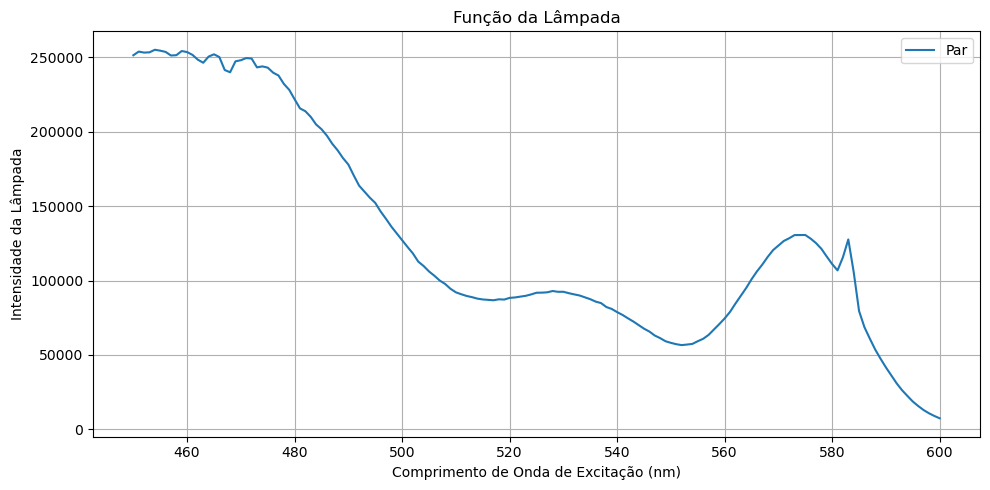

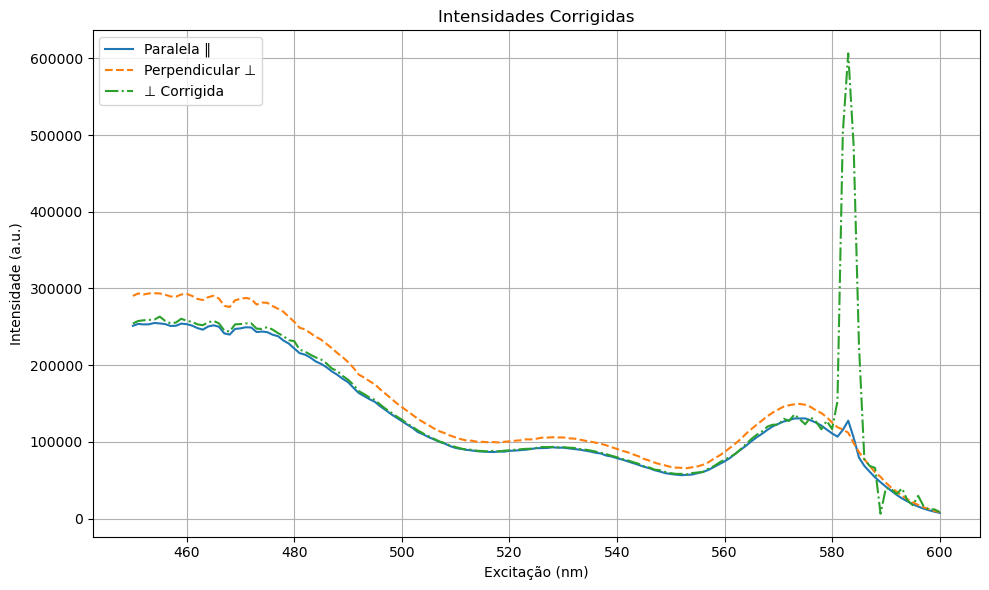

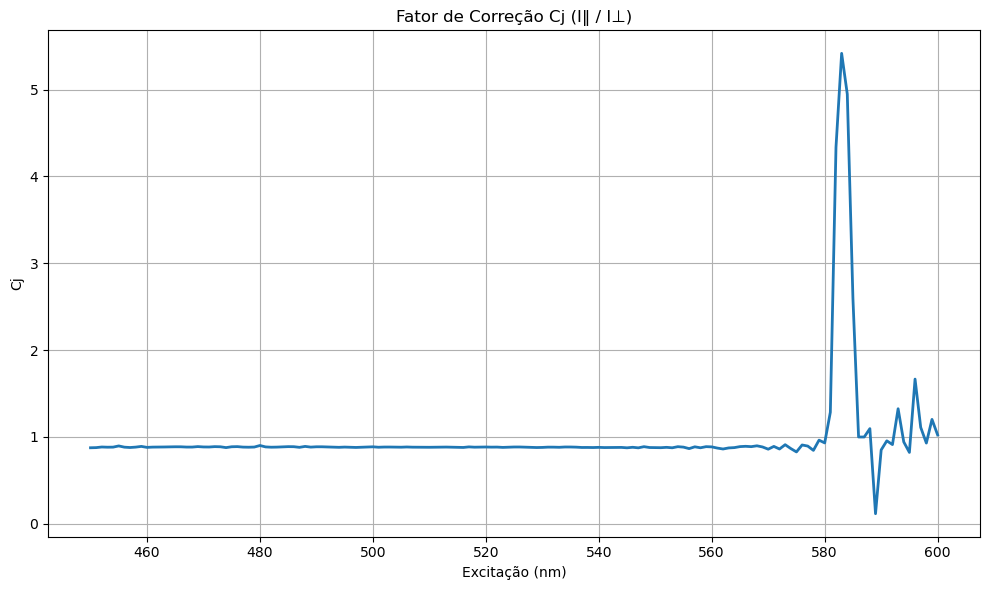

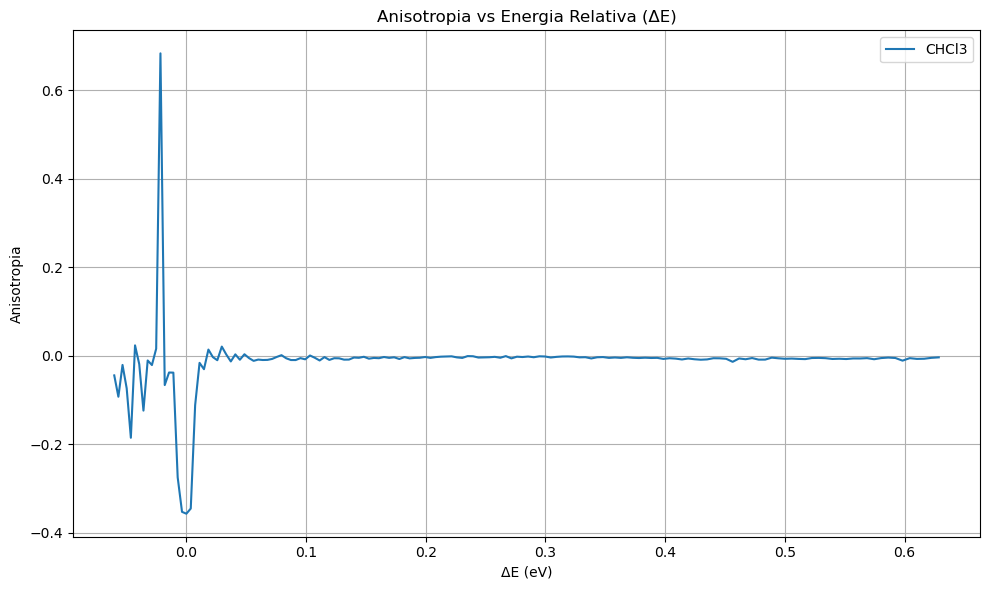

In [7]:
plot_lamp_function(df_final["Excitation Wavelength (nm)"], df_final["Par Avg"], label="Par")
plot_corrected_intensities(df_final)
plot_correction_factor(df_final)
plot_anisotropy_energy(df_final, label="CHCl3")
